# CS-5600/6600 Lecture 7 - Bagging and Random Forests

**Instructor: Dylan Zwick**

*Weber State University*

Reference: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) by Aurélien Géron - [Ensemble Learning and Random Forests](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import random

from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml


from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


<center>
  <img src="https://imgs.xkcd.com/comics/forest_walk.png" alt="Forest Walk from xkcd">
</center>

You may be wondering what this has to do with random forests. The answer is - nothing, really, except being about a "random" encounter in a forest. (It's a reference to [this](https://www.fbi.gov/history/famous-cases/db-cooper-hijacking).)

In our last lecture we learned about decision trees and how they're grown. We also learned that, while decision trees have the great virtue of being reasonably explainable (how they arrive at their decision can be understood by a person in a way that makes sense to that person), they have the (probably greater) vice of being mediocre predictors. Most of the time, in a pinch, people would rather have a correct answer that they don't understand, and not an incorrect one that they do.

So, what then is the point of decision trees? Well, it turns out they can be saved through - [democracy](https://youtu.be/DU-RuR-qO4Y?si=UDsNBuGhRLarETkm)! More specifically, the power of decision trees can increase significantly using *ensemble methods*.

## Ensemble Methods

Ensemble methods make their decision through a vote, and the decision of the group is either a (possibly weighted) average (in the regression context) or a (possibly weighted) plurality vote (in the classification context).

The idea is that we start by training $m$ different classifiers $(C_{1},C_{2},\ldots,C_{m})$. Depending on the technique, we can be build the different classifiers from different classification algorithms, or we can build them with the same base classification algorithm, but different datasets. We then run all these trained classifiers on a classification problem, get their answers, and then let these answers vote.

Why can this work better than an individual classifier? Let's look at an example. If we assume that we have a binary classification task, and each model has an *independent* error rate $\epsilon$, then we can express the error probability of an ensemble as a probability mass function of a binomial distribution:

<center>
    $\displaystyle P(y \geq k) = \sum_{m = k}^{n} \binom{n}{m}\epsilon^{m}(1-\epsilon)^{n-m}$
</center>

If, for example, $\epsilon = .25$ (25%), and we have $11$ classifiers, then the error rate would be $0.034$ (3.4%). A big improvement!

More generally, as the base error increases, we see an ensemble error graph that looks like this:

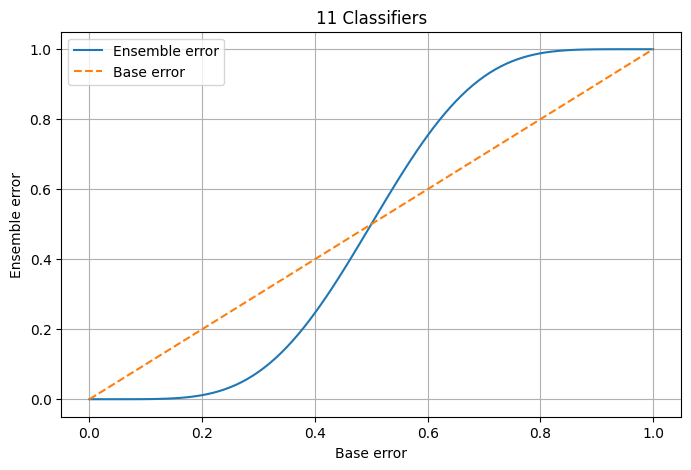

In [ ]:
bclassifiers = 11
x_values = np.arange(0,1.01,.01)
y_values = np.array([np.sum(np.array([math.comb(classifiers,m)*value**m*(1-value)**(classifiers-m) for m in range(math.ceil(classifiers / 2),classifiers+1)])) for value in x_values])

plt.figure(figsize=(8, 5))
plt.plot(x_values,y_values, label="Ensemble error")
plt.plot(x_values,x_values, "--", label="Base error")
plt.xlabel("Base error")
plt.ylabel("Ensemble error")
plt.legend(loc="upper left")
plt.title(str(classifiers) + " Classifiers")
plt.grid()
plt.show()

As another example, let's suppose we have a coin that lands heads 51% of the time (barely more than half). If we flip the coin once, there's a 49% chance we get more heads than tails. If we flip the coin three times, there's a 48.5% chance we get more heads than tails. However, if we flip the coin many times - like 1,000 or 10,000 - it's very unlikely that we'll get more heads than tails.

We can investigate this empirically with the code below:

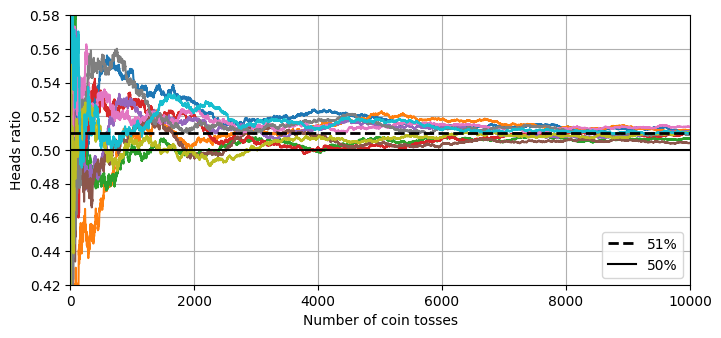

In [ ]:
heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

This is 10 simulations of flipping a coin 10,000 times, with the heads percentage on the vertical and the number of tosses on the horizontal. We can see that at 10,000 tosses, every one has more heads than tails.

We can run (but not chart) this simulation 10,000 times instead of 10, with 100,000 tosses instead of 10,000. Let's see how many times there are more heads than tails after 100,000 tosses:

In [ ]:
# Parameters
heads_proba = 0.51
trials = 10000
tosses = 100000

# Simulate all trials at once
# Generate a matrix of random values and count the number of heads in each trial
coin_tosses_matrix = np.random.rand(trials, tosses) < heads_proba
heads_counts = np.sum(coin_tosses_matrix, axis=1)

# Count how many trials had more tails than heads
more_tails = np.sum(heads_counts <= tosses / 2)

print(more_tails)

0


So, basically never!

So - all we need to do is find a bunch of mediocre predictors, and we can create, [Voltron](https://en.wikipedia.org/wiki/Voltron)-style, an amazing predictor. Right?

Well, that's the goal, but unfortunately it's not that easy. In our example calculations above, we've assumed that all the predictors are independent, which means what one predicts is independent of the others. That's almost never the case, particularly if the predictors are all trained on the same data.

However, even if the predictors aren't independent, an ensemble will still frequently do better.

### Example Ensemble Classification Problem

Let's use an ensemble on an actual classification problem. Sklearn provides a *VotingClassifier* class that's quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier. Let's try it on the moon's dataset. Don't worry about what these models are right now, just know they're different binary classifiers.

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('logistic_regression', LogisticRegression(random_state=42)),
        ('random_forest', RandomForestClassifier(random_state=42)),
        ('support_vector', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('support_vector', SVC(random_state=42))])

We can check out the individual trained estimators in our ensemble model with the *estimators_* attribute:

In [ ]:
voting_clf.estimators_

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 SVC(random_state=42)]

We can also view them as a dictionary (key / value pairs) with the *named_estimators_* attribute:

In [ ]:
voting_clf.named_estimators_

{'logistic_regression': LogisticRegression(random_state=42),
 'random_forest': RandomForestClassifier(random_state=42),
 'support_vector': SVC(random_state=42)}

Let's see how our three estimators do predicting our dataset:

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

logistic_regression = 0.864
random_forest = 0.896
support_vector = 0.896


Not bad. Now, let's see how the ensemble does. First, let's check out how it does on one sample:

In [ ]:
voting_clf.predict(X_test[:1])

array([1])

So, the ensemble prediction is $1$. If we look at the individual model predictions we get:

In [ ]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

So, two of the individual predictions were $1$, while one was $0$, and so the prediction $1$, er, won.

If we check out the accuracy of the ensemble predictor over all the sample data we get:

In [ ]:
voting_clf.score(X_test, y_test)

0.912

Better than any of the individual predictors! Democraty FTW!

In our example ensemble calculation above, we used three fairly different predictors - logistic regression, random forest, and support vector - to create our prediction. However, the number of distinct prediction algorithms is somewhat limited, and it's hard to come up with new ones.

So, how can we generate a bunch of predictors for our ensemble? Well, instead of using different models, we can use the some model but with different data. OK, but getting data isn't always easy. That's where *bootstrapping * and *bagging* (short for *b*ootstrap *agg*regat*ing*) comes in.

## Bootstrapping

The idea behind bagging is that you create a bunch of datasets from your original one through bootstrapping. What is "bootstrapping"? Well, the name is based upon the notion of "pulling yourself up by your own bootstraps", an impossibility that more broadly means doing what you can to improve yourself with the only resources you have available.

The idea behind bootstrapping is that you build a different sample from the one and only sample that you have. How in the world do you do that? Well, you do it through resampling *with replacement*. So, you resample from your existing sample, but you allow for the possibility of a given value being chosen more than once.

Let's first take a look at this using some simulated data. First, we'll create a dataframe

In [ ]:
#The function np.random.normal returns a random number from a normal (a.k.a Gaussian) distribution with mean loc and standand deviation scale.
np.random.normal(loc = 10, scale = 3)

5.619744107902639

We'll grab 1000 random samples from a normal distribution:

In [ ]:
samples = np.random.normal(loc=10, scale=3, size=1000)

Now, we'll plot the histogram of this distribution, marking its mean and 95% "confidence" internal (the interval within which 95% of the samples occur).

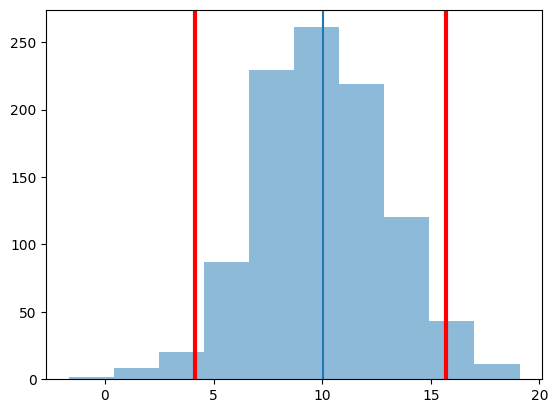

In [ ]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    # 95% confidence interval
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)

plot_hist(samples)

It appears normally distributed around its mean. (Note this is exactly what we'd expect from the central limit theorem.)

In bootstrapping, we start with our sample, and we resamble from it with replacement. So, we pick a value, record it, *put it back*, and then pick again.

In [ ]:
samples_bootstrap = np.random.choice(samples,size=len(samples),replace=True)

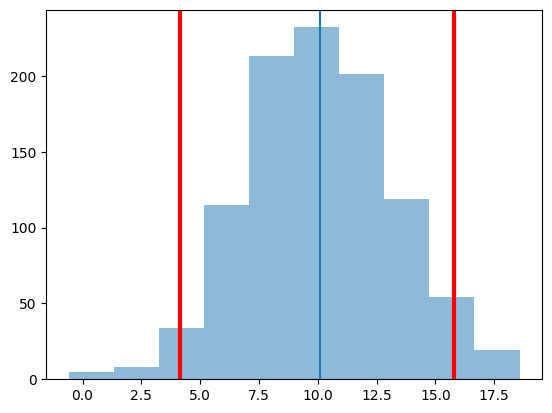

In [ ]:
plot_hist(samples_bootstrap)

We can do this again if we'd like.

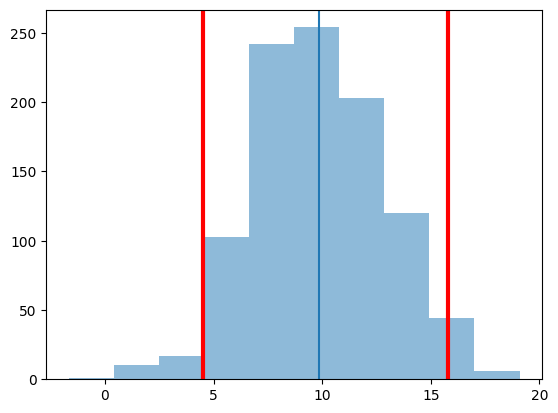

In [ ]:
samples_bootstrap_2 = np.random.choice(samples,size=len(samples),replace=True)
plot_hist(samples_bootstrap_2)

These bootstrapped samples are definitely different than our original, but they're similar.

## Bagging

Bagging (bootstrap aggregating) is the process of creating an ensemble of classifiers by using the same base classification algorithm (like a decision tree) and a bunch of different datasets created from an original dataset through bootstrap sampling.

Let's try this on our moons dataset. We'll create an ensemble classifier using a decision tree as our base algorithm, and 500 classifiers in the ensemble.

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000, n_jobs=-1, random_state=42) #The n_jobs parametr specifies the number of CPUs to use. Setting it to -1 means use as many as are available.
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, random_state=42)

Below, you'll see a plot of the decision boundary of a single decision tree against the decision boundary of the ensemble.

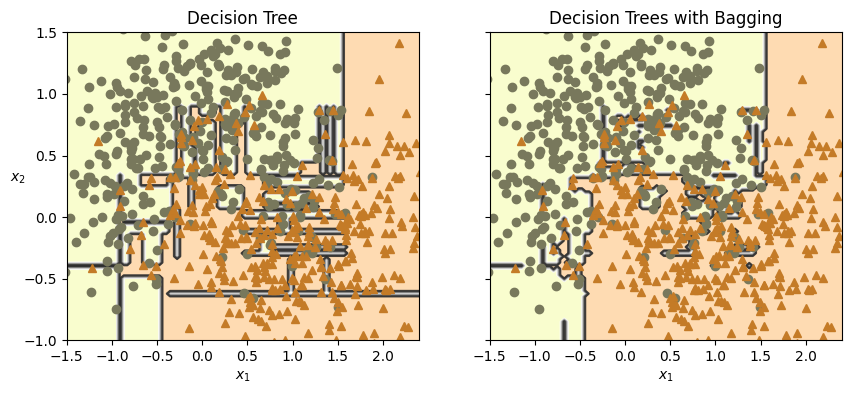

In [ ]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

The ensemble prediction has a more sensible boundary, and will likely generalize better. Which, if we examine it on the test set, we can see it does.

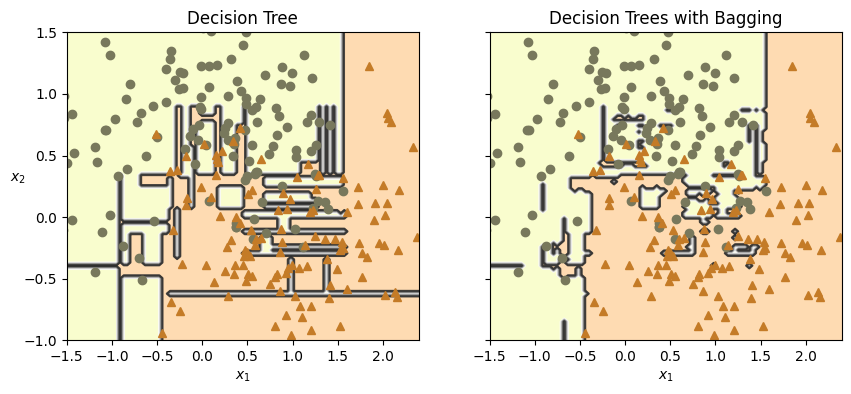

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_test, y_test)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_test, y_test)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

### Out-of-Bag Evaluation

With bagging, some training instances may be sampled several times for any predictor, while others may not be samples at all. It can be proved mathematically that on average about 37% (slightly more than one-third) of the available original sample won't appear in a bootstrap sample the same size as the original. The samples that don't appear in the bootstrap sample are called *out-of-bag* (OOB) instances. Note the OOB instances for one predictor are not the same as those for another.

These OOB instances are nice in that they provide us with an immediately available validation set! If there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance. Once we have a prediction for each instance, we can compute an ensemble prediction accuracy (or any other metric).

With sklearn we can do this by setting *oob_score=True* when creating a *BaggingClassifier*. For example:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8386666666666667

According to this evaluation, we'd expect to get about 84% accuracy on the test set. Let's see:

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.84

Nailed it!

##Random Forests

A random forest is an ensemble of decision trees, trained via the bagging method.

The random forest algorithm, however, introduces extra randomness when growing its trees. Instead of searching for the best feature when splitting a node, it searches for the best feature among a random subset of features. By default, it uses $\sqrt{n}$ features (where $n$ is the total number). This results in greater tree diversity - trading (again) a higher bias for a lower variance, and generally yielding an overall better model.

We can try it out on our moons dataset.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.868

A bit better than our bagging classifier above! That extra randomness helped us out.

### Feature Importance

A call thing about how random forests are implemeted in sklearn is they make it easy to masure the relative importance of each features. This is done by looking at how much the tree notes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it's a weighted average, where each node's weight is equal to the number of training samples associated with it.

Sklearn computes this score automatically for each feature after training, then it scales the results so the sum of all importances is equal to 1. You can access the result using the *feature_importances_* variable.

For example, the following code trains a random forest on the iris dataset.

In [ ]:
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


It seems the most important features are the petal length and width, while sepal length and width are rather unimportant.

We can also train a random forest on the MNIST dataset and plot each pixel's importance.

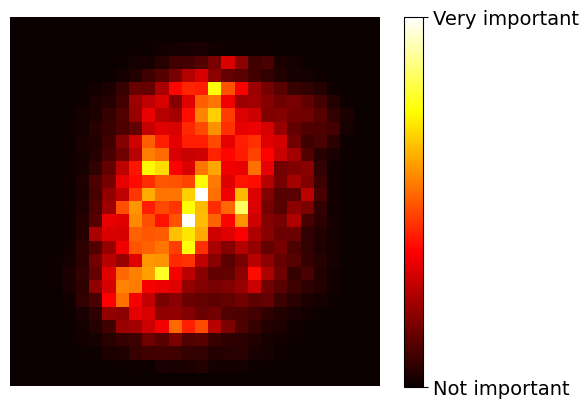

In [ ]:
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

It looks like the pixels towards the middle of the image are the most important, which makes sense.

## References



* [The original paper on bagging predictors](https://www.stat.berkeley.edu/~breiman/bagging.pdf)
* [The original paper on random forests](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
* [Series of videos on random forests](https://youtu.be/J4Wdy0Wc_xQ?si=30CD0ZuuXTCJUAqg)


* If you live in Weber County and want to be part of our ensemble, you can register to vote [here](https://www.weberelections.gov/registertovote).

* *Song of the Day* - [Trees](https://youtu.be/iDM8fXhRdWs?si=xeu6DDwqejRZwE2X) by Rush
